# Example patching and analysis notebook for FHMCAnalysis
* Author: Nathan A. Mahynski
* Last Modified: 01/05/17

## Import FHMCAnalysis

In [2]:
import sys, os
import numpy as np
FHMC_PATH = '../../../../'
sys.path.append(FHMC_PATH)
import FHMCAnalysis
import FHMCAnalysis.moments.histogram.one_dim.ntot.gc_hist as hG
import FHMCAnalysis.moments.win_patch.omcs_patch as wp
import FHMCAnalysis.moments.win_patch.omcs_equil as we

## Patch windows and test for equilibration

In [3]:
temp = 0.90

In [4]:
src = './T_%.2f'%temp 
seq = wp.get_patch_sequence(src)
seq = we.test_nebr_equil(seq, 3.0)
composite = src+'/composite.nc'
wp.patch_all_windows(seq, composite)

patching  ./T_0.90/21/tmmc-Checkpoint-12_lnPI.dat::./T_0.90/21/extMom-Checkpoint-12.dat::./T_0.90/21/eHist-Checkpoint-12.dat::./T_0.90/21/pkHist-Checkpoint-12-[536,557] ./T_0.90/20/tmmc-Checkpoint-34_lnPI.dat::./T_0.90/20/extMom-Checkpoint-34.dat::./T_0.90/20/eHist-Checkpoint-34.dat::./T_0.90/20/pkHist-Checkpoint-34-[521,542]
Optimization terminated successfully.
         Current function value: 0.000050
         Iterations: 16
         Function evaluations: 32
patching  ./T_0.90/21/tmmc-Checkpoint-12_lnPI.dat::./T_0.90/21/extMom-Checkpoint-12.dat::./T_0.90/21/eHist-Checkpoint-12.dat::./T_0.90/21/pkHist-Checkpoint-12-[521,557] ./T_0.90/19/tmmc-Checkpoint-77_lnPI.dat::./T_0.90/19/extMom-Checkpoint-77.dat::./T_0.90/19/eHist-Checkpoint-77.dat::./T_0.90/19/pkHist-Checkpoint-77-[505,527]
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 17
         Function evaluations: 34
patching  ./T_0.90/21/tmmc-Checkpoint-12_lnPI.dat::./T_0.90/21/extMo

('./T_0.90/9/final_lnPI.dat::./T_0.90/9/final_extMom.dat::./T_0.90/9/final_eHist.dat::./T_0.90/9/final_pkHist-[320,348]',
 8.3540014672841003e-05)

## Example of phase equilibrium calculation

In [5]:
mu_ref = [0.0] # Simulations were performed at mu_1 = 0
beta_ref = 1.0/temp # Simulations were performed at 1/T
smooth = 10 # How many points in N_tot space to smooth lnPI over when looking for maxima
hist = hG.histogram (composite, beta_ref, mu_ref, smooth)

### Search for a good guess to start phase coexistence search from using reweighting

In [6]:
lnPI = []
for mu_1 in np.linspace(-5,0,20):
    hist.reweight(mu_1) 
    if (hist.is_safe()): 
        hist.thermo() 
        result = hist.data['thermo']
        lnPI.append((hist.data['ln(PI)'], mu_1))

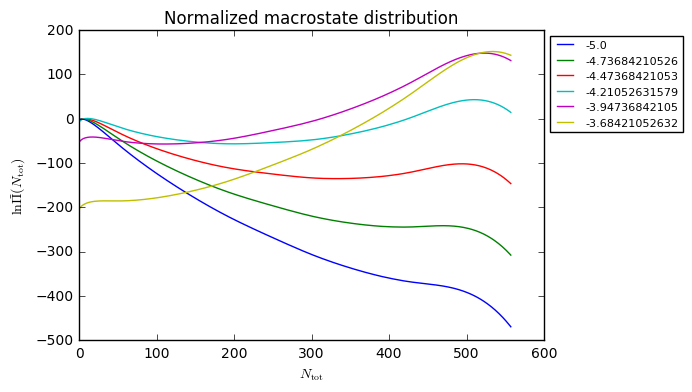

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
n = np.arange(len(lnPI[0][0]))
for lp in lnPI:
    plt.plot(n, lp[0], label=str(lp[1]))
plt.xlabel(r'$N_{\rm tot}$')
plt.ylabel(r'${\rm ln}{\tilde{\Pi}}(N_{\rm tot})$')
plt.title('Normalized macrostate distribution')
plt.legend(loc='best', prop={'size':8}, bbox_to_anchor=(1,1))

### Search for phase coexistence (at the simulation temperature)

In [8]:
mu_guess = -3.94 # choose a mu where 2 peaks appear in plot above, may need to be fairly close (can be finicky)

* These results may be compared against NIST reference website: https://www.nist.gov/mml/csd/chemical-informatics-research-group/sat-tmmc-liquid-vapor-coexistence-properties-square-well

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 36

mu_{coexist}/kT = [-4.47264321]

Phase #1
U/N = -0.228518505977
density = 0.0144348886091
Free Energy/kT = -9.28510447143
P =  0.01146309194
or P =  0.0114628613305

Phase #2
U/N = -5.49075169
density = 0.692974021299
Free Energy/kT = -9.28473084907
P =  0.0114626306779
or P =  0.0114628613305


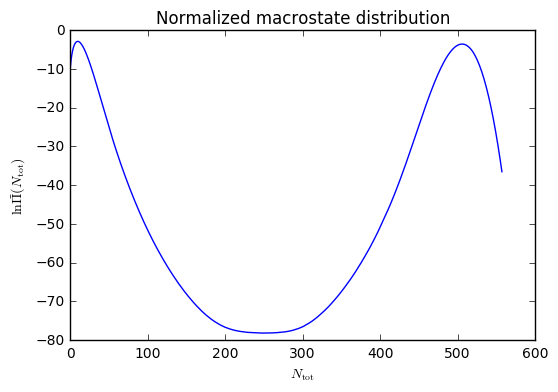

In [13]:
lnZ_tol = 1.0e-6 # error in free energy between the two phases
beta = beta_ref
equil_hist = hist.find_phase_eq(lnZ_tol, mu_guess, beta) # search for phase equilibrium at this temperature
plt.figure()
if (equil_hist.is_safe()): # check that max(lnPI) is far enough from the edge
    equil_hist.thermo() # compute thermodynamic properties
    plt.plot(n, equil_hist.data['ln(PI)'])
    plt.xlabel(r'$N_{\rm tot}$')
    plt.ylabel(r'${\rm ln}{\tilde{\Pi}}(N_{\rm tot})$')
    plt.title('Normalized macrostate distribution')

    print '\nmu_{coexist}/kT =', equil_hist.data['curr_mu']*equil_hist.data['curr_beta']
    for phase in equil_hist.data['thermo']:
        print '\nPhase #'+str(phase+1)
        print 'U/N =', equil_hist.data['thermo'][phase]['u']/equil_hist.data['thermo'][phase]['ntot']
        print 'density =', equil_hist.data['thermo'][phase]['density']
        print 'Free Energy/kT =', equil_hist.data['thermo'][phase]['F.E./kT']
        print 'P = ',-equil_hist.data['thermo'][phase]['F.E./kT']/equil_hist.data['volume']/equil_hist.data['curr_beta']
        print 'or P = ', np.log(np.sum(np.exp(equil_hist.data['ln(PI)'])/np.exp(equil_hist.data['ln(PI)'][0]))/2)/equil_hist.data['volume']/equil_hist.data['curr_beta']